In [13]:
import json
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from time import time
import os
import shutil
import math
from statistics import mean
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw

# Funciones del extra

### Se ha modificado la función de calcular IOU

In [14]:
def translate_coco_to_images_net(searched_label):
    label = ""
    if (searched_label in ["n02105855", "n02114548", "n02089973", "n02097209", "n02111277", "n02112018", "n02093859"]) :
        label = "dog"
    elif (searched_label in ["n02930766", "n03930630"]) :
        label = "car"
    elif (searched_label in ["n03895866"]) :
        label = "train"
    elif (searched_label in ["n07742313"]) :
        label = "apple"
    return label

def find_xml_file(path, jpeg_filename):
    # Get the base filename without extension
    base_filename = os.path.splitext(os.path.basename(jpeg_filename))[0]

    # Construct the XML filename
    xml_filename = os.path.join(path, f"{base_filename}.xml")

    # Check if the XML file exists
    if os.path.exists(xml_filename):
        return xml_filename
    else:
        return None

def clear_directory(directory_path):
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
    os.makedirs(directory_path)

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = []

    for object_elem in root.findall(".//object"):
        name_elem = object_elem.find("name")
        bbox_elem = object_elem.find("bndbox")

        if name_elem is not None and bbox_elem is not None:
            name = name_elem.text
            xmin = int(bbox_elem.find("xmin").text)
            ymin = int(bbox_elem.find("ymin").text)
            xmax = int(bbox_elem.find("xmax").text)
            ymax = int(bbox_elem.find("ymax").text)

            annotation = {
                'name': name,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            }

            annotations.append(annotation)

    return annotations

def calculate_iou(box1, box2):
    # Calculate the intersection coordinates
    inter_xmin = max(box1[0], box2[0])
    inter_ymin = max(box1[1], box2[1])
    inter_xmax = min(box1[2], box2[2])
    inter_ymax = min(box1[3], box2[3])

    # Calculate the area of intersection
    inter_area = max(0, inter_xmax - inter_xmin + 1) * max(0, inter_ymax - inter_ymin + 1)

    # Calculate the area of both boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou


def calculate_absolute_difference(box1, box2):
    # Calculate absolute differences for each coordinate
    diff_xmin = abs(box1[0] - box2[0])
    diff_ymin = abs(box1[1] - box2[1])
    diff_xmax = abs(box1[2] - box2[2])
    diff_ymax = abs(box1[3] - box2[3])

    # You can sum up the absolute differences or use any other measure
    total_absolute_difference = diff_xmin + diff_ymin + diff_xmax + diff_ymax
    return total_absolute_difference

def get_scores(results, threshold):
    TP = 0
    FP = 0
    FN = 0
    # R2 is non-significant because all actual values are 1
    mse = 0
    mae = 0
    mlse = 0

    n = len(results)
    for result in results:
        if result == 0:
            FN += 1
        elif result < threshold:
            FP += 1
        else:
            TP += 1

        mse += (1 - result) ** 2
        mae += abs(1 - result)
        mlse += (math.log(1 + 1) - math.log(1 + result))**2
    mse /= n
    mae /= n
    mlse /= n

    precision = TP/(TP + FP)
    recall = TP/(TP + FN)

    f1 = 2 * (precision * recall) / (precision + recall)

    return {"average_iou" : mean(results),
            "precision" : precision,
            "recall" : recall,
            "f1" : f1,
            "mse" : mse, 
            "mae" : mae, 
            "mlse" : mlse, }

### Carga del modelo pre entrenado de TensorFlow

In [15]:
model_url = "https://tfhub.dev/tensorflow/efficientdet/d7/1"

# Cargar el modelo desde TensorFlow Hub
#model = hub.load(model_url)
model = hub.load("https://www.kaggle.com/models/tensorflow/efficientdet/frameworks/TensorFlow2/variations/d7/versions/1")

KeyboardInterrupt: 

### Configuración previa

In [ ]:
# Lista para almacenar las cajas delimitadoras predichas
predicted_boxes_list = []
inicio = time()

folder_path = "../../testImagesNet/Data/"
annotations_directory = "../../testImagesNet/Annotations/"
output_directory = "../../output/images/tensorflow_pretrained/"
clear_directory(output_directory)

image_list = []
image_path_list = []

# List all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.png', '.jpeg', '.JPEG')):  # You can add more extensions if needed
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the image and append it to the list
        img = cv2.imread(file_path)
        image_list.append(img)
        image_path_list.append(file_path)
    


true_boxes_list = []

# Recorrer las imágenes y obtener las anotaciones de ground truth

resources_directory = "../../resources/"

# Load COCO class labels
class_labels = []
with open(resources_directory + "faster_rcnn_coco.names", "rt") as f:
    class_labels = f.read().rstrip('\n').split('\n')

### Inferencias sobre las imágenes de ImagesNet

In [ ]:
# Lista para almacenar las cajas delimitadoras predichas
predicted_boxes_list_tf = []
results = {}
# Realizar inferencias en cada imagen
for image_path, image_file in zip(image_path_list, image_list):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Realizar inferencias en la imagen
    outputs = model([image])

    # Obtener las detecciones
    boxes = outputs["detection_boxes"].numpy()
    scores = outputs["detection_scores"].numpy()
    classes = outputs["detection_classes"].numpy().astype(np.int32)

    # (Opcional) Filtrar detecciones por confianza
    confidence_threshold = 0.5

    xml_data = parse_xml(find_xml_file(annotations_directory, image_path))
    
    for target in xml_data:
        iou = 0

        searched_label = translate_coco_to_images_net(target["name"])

        image_iou_dict = {}
        if searched_label in results:
            image_iou_dict = results[searched_label]
        if image_path not in image_iou_dict:
            image_iou_dict[image_path] = []

        for predicted_boxes, predicted_scores, predicted_classes in zip(boxes, scores, classes) :
            for box, score, label in zip(predicted_boxes, predicted_scores, predicted_classes):
                if score < 0.5 or label - 1 >= len(class_labels):
                    break
                # Obtener el tamaño de la imagen
                image_size = image.shape[:2]

                # Convertir las coordenadas normalizadas a píxeles reales
                box_minmax = [
                    box[1] * image_size[1],  # x_min
                    box[0] * image_size[0],  # y_min
                    box[3] * image_size[1],  # x_max
                    box[2] * image_size[0]   # y_max
                ]

                draw_box = [int(num) for num in box_minmax]
                # Draw the annotated box on the image
                color = (0, 255, 0)  # You can change the color as needed
                cv2.rectangle(image_file, (draw_box[0], draw_box[1]), (draw_box[2], draw_box[3]), color, 2)
                cv2.putText(image_file, class_labels[label - 1], (draw_box[0], draw_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                if class_labels[label - 1] == searched_label:
                    # Calcular IoU
                    new_iou = calculate_iou(box_minmax, [target["xmin"], target["ymin"], target["xmax"], target["ymax"]])

                    if np.any(new_iou > iou):
                        iou = new_iou

        # Añadir el resultado al diccionario
        image_iou_dict[image_path].append(iou)
        results[searched_label] = image_iou_dict
        
        # Save the annotated image
        filename = os.path.join(output_directory, os.path.basename(image_path))
        cv2.imwrite(filename, image_file)

duracion = time() - inicio

### Visualización de resultados

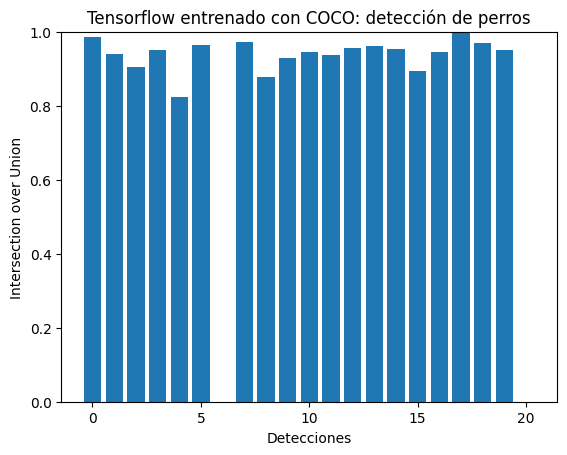

In [6]:
# Visualización de resultados en gráficos y exportación a CSV
score_export_folder_path = "../../output/scores/"

data = results["dog"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('Tensorflow entrenado con COCO: detección de perros')

# Show the plot
plt.show()

In [7]:
data = results["car"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('TensofrFlow entrenado con COCO: detección de coches')

# Show the plot
plt.show()

KeyError: 'car'

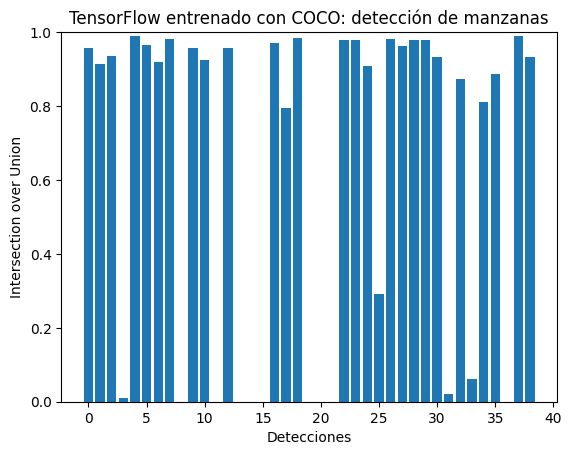

In [ ]:
data = results["apple"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('TensorFlow entrenado con COCO: detección de manzanas')

# Show the plot
plt.show()

### Métricas

In [ ]:
threshold = 0.5
# Specify the file path where you want to export the dictionary
score_export_folder_path = "../../output/scores/"

In [8]:
data = results["dog"]
threshold = 0.5
merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

scores["time"] = duracion

score_export_file_path = "tensorflow_dog_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.8512365798405027
Precision: 1.0
Recall: 0.9047619047619048
F1-score: 0.9500000000000001
MSE: 0.09984645423442753
MAE: 0.1487634201594973
MLSE: 0.04697884839730723


In [11]:
data = results["train"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

scores["time"] = duracion

score_export_file_path = "tensorflow_train_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.7819871186550055
Precision: 0.88
Recall: 0.9565217391304348
F1-score: 0.9166666666666666
MSE: 0.15532730068679745
MAE: 0.2180128813449945
MLSE: 0.07115730276053088


In [12]:
data = results["apple"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

scores["time"] = duracion

score_export_file_path = "tensorflow_apple_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.6365490988005269
Precision: 0.8666666666666667
Recall: 0.7428571428571429
F1-score: 0.8
MSE: 0.31999190784049936
MAE: 0.3634509011994732
MLSE: 0.15070107858612772
